This notebook analyzes customer churn based on the Telco customer churn dataset. I have made presentation that makes it easier to look at the charts and present.

# What is customer churn?

Customers churn when they terminate services with a company. In the context of Telco, customers churn when they stop using Telephone/TV services provided. Reasons for churn:

-  They simply no longer use their services 
-  They go to Telco's competitors
    
Let us define a main problem that any financial company faces: Customer churn. They want to know exactly "Who is Churning"? Let's extact some insights.

In [43]:
import pandas as pd
import plotly
import plotly.graph_objs as go
import scipy.stats as stats
import numpy as np

from plotly import  __version__
from plotly.offline import *
from scipy.stats import mannwhitneyu, ttest_ind

In [44]:
init_notebook_mode(connected=True)  # Plotly graphs in Jupyter

In [45]:
data = pd.read_csv('F:/6.Data_Science_projects/GitHub Projects/Customer_Churn_Analysis/Data/cust_churn.csv')
data.head(n=5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


We define some functions which will perform the crux of the Hypothesis testing in this notebook. More explanation in the Appendix

In [46]:
def is_normal(group):
    """Check if input ndarray is normally distributed using the Shapiro Wilk Test"""
    wval, pval = stats.shapiro(group)
    if len(group) > 5000: # W-stat is more accurate for larger sample sizes
        if wval < 0.05: return False
    if pval < 0.05: return False
    return True

def has_eq_var(group_1, group_2):
    """Check the property of homoscendacity (equal variance) using the Levene test"""
    _, pval = stats.levene(group_1, group_2) 
    if pval < 0.05: return False
    return True

def stat_test(group_1, group_2):
    """Between 2 groups, if the conditions of normality + homoscendacity hold, perform 
    T-Test, otherwise perform the Mann Whiteny U Test."""
    if is_normal(group_1) and is_normal(group_2):
        if has_eq_var(group_1, group_2): 
            print("Performing T-Test ...")
            return stats.ttest_ind(group_1, group_2)
        print("Performing T-Test with unequal variance ...")
        return stats.ttest_ind(group_1, group_2, equal_var=False)
    print("Performing U-Test ...")
    return mannwhitneyu(group_1, group_2)

# 1. Active Vs Churned Stats

Let's get some ball park numbers to get a feel for the data. We assume the data is all customer data ever.

In [47]:

# Active users are those who haven't churned
active_users = data[data['Churn'] == 'No']
churned_users = data[data['Churn'] == 'Yes']

active_internet_users = active_users[active_users['InternetService'] != 'No']
churned_internet_users = churned_users[churned_users['InternetService'] != 'No']

active_phone_users = active_users[active_users['PhoneService'] != 'No']
churned_phone_users = churned_users[churned_users['PhoneService'] != 'No']

In [48]:
labels_active = ['Internet only','Phone only','Internet + Phone']
values_active = [
    active_internet_users[active_internet_users['PhoneService'] == 'No'].shape[0],
    active_phone_users[active_phone_users['InternetService'] == 'No'].shape[0],
    active_internet_users[active_internet_users['PhoneService'] != 'No'].shape[0]
]
trace_active = go.Pie(labels=labels_active, values=values_active, hole = .45, 
                      domain={"x": [0, .48]}, hoverinfo='label+percent+value')

labels_churned = ['Internet only','Phone only','Internet + Phone']
values_churned = [
    churned_internet_users[churned_internet_users['PhoneService'] == 'No'].shape[0],
    churned_phone_users[churned_phone_users['InternetService'] == 'No'].shape[0],
    churned_internet_users[churned_internet_users['PhoneService'] != 'No'].shape[0]
]
trace_churned = go.Pie(labels=labels_churned, values=values_churned, hole = .45,
                       domain={"x": [0.52, 1]}, hoverinfo='label+percent+value')

layout={
    'title': 'Big Stats [Number of Users] for Active and Churned users',
    'annotations': [
        {'text': 'Active Users',                
         "x": 0.16, # Position of Text
         "y": 0.5,
         'showarrow':False,
         'font':{'size': 18}
        }, 
        {'text': 'Churned Users',
         "x": 0.85,
        "y": 0.5,
        'showarrow':False,
        'font':{'size': 18}
        }
    ]
}

fig = go.Figure(dict(data=[trace_active, trace_churned], layout=layout))
iplot(fig)

Observations: Aside from the raw numbers

- Whether we consider Internet, Phone, or both, we have currently many more active users than churned users.
    
- Just because 85% of the users who churned had both internet + phone doesn’t mean the combo “internet + phone” is bad.       They constitute 63% of our active user base after all.
    
- Similarly, 6% churned user had only phone services doesn’t mean the "phone only" policy is good. They don’t have as many active users to begin with


In [49]:
labels_active = ['Fiber optic','DSL','No Internet']
values_active = [
    active_phone_users[active_phone_users['InternetService'] == 'Fiber optic'].shape[0],
    active_phone_users[active_phone_users['InternetService'] == 'DSL'].shape[0],
    active_phone_users[active_phone_users['InternetService'] == 'No'].shape[0]
]
trace_active = go.Pie(labels=labels_active, values=values_active, hole = .45, 
                      domain={"x": [0, .48]}, hoverinfo='label+percent+value', textinfo='value+percent')

labels_churned = ['Fiber optic','DSL','No Internet']
values_churned = [
    churned_phone_users[churned_phone_users['InternetService'] == 'Fiber optic'].shape[0],
    churned_phone_users[churned_phone_users['InternetService'] == 'DSL'].shape[0],
    churned_phone_users[churned_phone_users['InternetService'] == 'No'].shape[0]
]
trace_churned = go.Pie(labels=labels_churned, values=values_churned, hole = .45,
                       domain={"x": [0.52, 1]}, hoverinfo='label+percent+value', textinfo='value+percent')

layout={
    'title': 'Internet Stats for Active and Churned Phone users',
    'annotations': [
        {'text': 'Active Users',                
         "x": 0.16, # Position of Text
         "y": 0.5,
         'showarrow':False,
         'font':{'size': 18}
        }, 
        {'text': 'Churned Users',
         "x": 0.85,
        "y": 0.5,
        'showarrow':False,
        'font':{'size': 18}
        }
    ]
}

fig = go.Figure(dict(data=[trace_active, trace_churned], layout=layout))
iplot(fig)

Observations: 

- 76% of our churned Phone users had a Fiber Optic internet service
- Over 30% of our current phone users have no internet plan.
    

# 1.2 Internet Users (Active Vs Churned)

In [50]:
group_1 = go.Box(
    x=active_internet_users['tenure'],
    name="Active")

# Get active users without the internet
group_2 = go.Box(
    x=churned_internet_users['tenure'],
    name="Churned")

info = [group_1, group_2]
title = "Lifetime of Active Vs Churned Internet Users"
iplot({
            "data": info, 
            "layout": {
                "title": title
            }
     })

In [51]:
group_1 = active_internet_users['tenure']
group_2 = churned_internet_users['tenure']
stat_test(group_1, group_2)

Performing U-Test ...


MannwhitneyuResult(statistic=1625854.0, pvalue=1.0298118100666476e-203)

Observation: Current active internet users have stay with us much longer than churned users

# 1.3 Phone Users (Active Vs Churned)

In [52]:
group_1 = go.Box(
    x=active_phone_users['tenure'],
    name="Active")

# Get active users without the internet
group_2 = go.Box(
    x=churned_phone_users['tenure'],
    name="Churned")

info = [group_1, group_2]
title = "Lifetime of Active Vs Churned Phone Users"
iplot({
            "data": info, 
            "layout": {
                "title": title
            }
     })

In [53]:
group_1 = active_phone_users['tenure']
group_2 = churned_phone_users['tenure']
stat_test(group_1, group_2)

Performing U-Test ...


MannwhitneyuResult(statistic=2082201.0, pvalue=3.507359587231067e-185)

Observation: Current active phone users have stay with us much longer than churned phone users

# 2 Internet Service

## 2.1 Internet Vs Non-Internet (Active users)

In [54]:

active_internet_tenure = go.Box(
    x=active_internet_users['tenure'],
    name="Internet")

# Get active users without the internet
active_non_internet_tenure = go.Box(
    x=active_users[~active_users.isin(active_internet_users)].dropna()['tenure'],
    name="Non-Internet")

info = [active_internet_tenure, active_non_internet_tenure]
title = "Lifetime of Internet Vs Non-Internet Active Users"
iplot({
            "data": info, 
            "layout": {
                "title": title
            }
     })

In [55]:
group_1 = active_internet_users['tenure']
group_2 = churned_internet_users['tenure']
stat_test(group_1, group_2)

Performing U-Test ...


MannwhitneyuResult(statistic=1625854.0, pvalue=1.0298118100666476e-203)

Observation: Active internet users have been with us longer than our non-Internet (phone only) users.

## 2.2 Internet Vs Non-Internet (Chunred users)

In [56]:
group_1 = go.Box(
    x=churned_internet_users['tenure'],
    name="Internet")

# Get active users without the internet
group_2 = go.Box(
    x=churned_users[~churned_users.isin(churned_internet_users)].dropna()['tenure'],
    name="Non-Internet")

info = [group_1, group_2]
title = "Lifetime of Internet Vs Non-Internet churned Users"
iplot({
            "data": info, 
            "layout": {
                "title": title
            }
     })

In [57]:
group_1 = churned_internet_users['tenure']
group_2 = churned_users[~churned_users.isin(churned_internet_users)].dropna()['tenure']
stat_test(group_1, group_2)

Performing U-Test ...


MannwhitneyuResult(statistic=58319.5, pvalue=7.470837736797634e-14)

Observations:

- Over half of the churned non-Internet (phone only) users churned in the first month of activation!
- Internet users churned later than non-internet users.

# 3 Phone Service

## 3.1 Phone Vs Non-Phone (Active)

In [58]:
group_1 = go.Box(
    x=active_phone_users['tenure'],
    name="Phone")

group_2 = go.Box(
    x=active_users[~active_users.isin(active_phone_users)].dropna()['tenure'],
    name="Non-Phone")

info = [group_1, group_2]
title = "Lifetime of Phone Vs Non-Phone Active Users"
iplot({
            "data": info, 
            "layout": {
                "title": title
            }
     })

In [59]:
group_1 = active_phone_users['tenure']
group_2 = active_users[~active_users.isin(active_phone_users)].dropna()['tenure']
stat_test(group_1, group_2)

Performing U-Test ...


MannwhitneyuResult(statistic=1175322.5, pvalue=0.28574926461158934)

Observation: The U-Test failed to reject the null hypothesis that the 2 groups come from the same distribution. Hence, Phone service for our active users has not affected their tenure with us.

## 3.2 Phone Vs Non-Phone (Churned users)

In [60]:
group_1 = go.Box(
    x=churned_phone_users['tenure'],
    name="Phone")

group_2 = go.Box(
    x=churned_users[~churned_users.isin(churned_phone_users)].dropna()['tenure'],
    name="Non-Phone")

info = [group_1, group_2]
title = "Lifetime of Phone Vs Non-Phone Churned Users"
iplot({
            "data": info, 
            "layout": {
                "title": title
            }
     })

In [61]:
group_1 = churned_phone_users['tenure']
group_2 = churned_users[~churned_users.isin(churned_phone_users)].dropna()['tenure']
stat_test(group_1, group_2)

Performing U-Test ...


MannwhitneyuResult(statistic=132442.5, pvalue=0.03651451721406969)

Observation: Churned users with phone service stayed slightly longer with us than those without phone service.

# 4 Internet Vs Phone Vs Internet + Phone

## 4.1 Internet Vs Phone Vs Internet + Phone (Active Users)

In [62]:
group_1 = go.Box(
    x=active_phone_users['tenure'][active_phone_users['InternetService'] == 'No'],
    name="Phone")

group_2 = go.Box(
    x=active_internet_users['tenure'][active_internet_users['PhoneService'] == 'No'],
    name="Internet")

group_3 = go.Box(
    x=active_internet_users['tenure'][active_internet_users['PhoneService'] != 'No'],
    name="Both")

info = [group_1, group_2, group_3]
title = "Lifetime of Active Phone Vs Internet Vs Both Users"
iplot({
            "data": info, 
            "layout": {
                "title": title
            }
     })

In [63]:
group_1 = active_phone_users['tenure'][active_phone_users['InternetService'] == 'No']
group_2 = active_internet_users['tenure'][active_internet_users['PhoneService'] == 'No']
group_3 = active_internet_users['tenure'][active_internet_users['PhoneService'] != 'No']

print("Phone Vs Both", stat_test(group_1, group_3))
print("Internet Vs Both", stat_test(group_2, group_3))
print("Internet Vs Phone", stat_test(group_2, group_1))

Performing U-Test ...
Phone Vs Both MannwhitneyuResult(statistic=1874583.0, pvalue=1.0637879108222935e-23)
Performing U-Test ...
Internet Vs Both MannwhitneyuResult(statistic=771462.0, pvalue=0.0041378067166320575)
Performing U-Test ...
Internet Vs Phone MannwhitneyuResult(statistic=319595.5, pvalue=4.5934604233844665e-05)


Observation: Users who have both internet and phone services usually stay longer than those with just internet. And these users stay longer than users with just phone.

## 4.2 Internet Vs Phone Vs Internet + Phone (Churned Users)

In [64]:
group_1 = go.Box(
    x=churned_phone_users['tenure'][churned_phone_users['InternetService'] == 'No'],
    name="Phone")

group_2 = go.Box(
    x=churned_internet_users['tenure'][churned_internet_users['PhoneService'] == 'No'],
    name="Internet")

group_3 = go.Box(
    x=churned_internet_users['tenure'][churned_internet_users['PhoneService'] != 'No'],
    name="Both")

info = [group_1, group_2, group_3]
title = "Lifetime of churned Phone Vs Internet Vs Both Users"
iplot({
            "data": info, 
            "layout": {
                "title": title
            }
     })

In [65]:
group_1 = churned_phone_users['tenure'][churned_phone_users['InternetService'] == 'No']
group_2 = churned_internet_users['tenure'][churned_internet_users['PhoneService'] == 'No']
group_3 = churned_internet_users['tenure'][churned_internet_users['PhoneService'] != 'No']

print("Phone Vs Both", stat_test(group_1, group_3))
print("Internet Vs Both", stat_test(group_2, group_3))
print("Internet Vs Phone", stat_test(group_2, group_1))

Performing U-Test ...
Phone Vs Both MannwhitneyuResult(statistic=51819.0, pvalue=2.4861731830303184e-14)
Performing U-Test ...
Internet Vs Both MannwhitneyuResult(statistic=119733.0, pvalue=0.008023996955921672)
Performing U-Test ...
Internet Vs Phone MannwhitneyuResult(statistic=6500.5, pvalue=1.2917063961208006e-06)


Observations:

- Users who had both internet and phone services stayed longer than those with just internet. And these users stay                longer than users with just phone.
        
- Over 50% Churned users with just phone services churned within 1 month of activation

# 5 Fiber Optic Vs DSL

## 5.1 Fiber Optic Vs DSL(Active Users)

In [66]:
group_1 = go.Box(
    x=active_internet_users['tenure'][active_internet_users['InternetService'] == 'Fiber optic'],
    name="Fiber Optic")

group_2 = go.Box(
    x=active_internet_users['tenure'][active_internet_users['InternetService'] == 'DSL'],
    name="DSL")

info = [group_1, group_2]
title = "Lifetime of Fiber Optic Vs DSL  Active Internet Users"
iplot({
            "data": info, 
            "layout": {
                "title": title
            }
     })

In [67]:
group_1 = active_internet_users['tenure'][active_internet_users['InternetService'] == 'Fiber optic']
group_2 = active_internet_users['tenure'][active_internet_users['InternetService'] == 'DSL']
stat_test(group_1, group_2)

Performing U-Test ...


MannwhitneyuResult(statistic=1558009.0, pvalue=2.498147703490333e-10)

Observation: Our Fiber Optic users are older customers than our current DSL users.

## 5.2 Fiber Optic Vs DSL(Churned Users)

In [68]:
group_1 = go.Box(
    x=churned_internet_users['tenure'][churned_internet_users['InternetService'] == 'Fiber optic'],
    name="Fiber Optic")

group_2 = go.Box(
    x=churned_internet_users['tenure'][churned_internet_users['InternetService'] == 'DSL'],
    name="DSL")

info = [group_1, group_2]
title = "Lifetime of Fiber Optic Vs DSL  Churned Internet Users"
iplot({
            "data": info, 
            "layout": {
                "title": title
            }
     })

In [69]:
group_1 = churned_internet_users['tenure'][churned_internet_users['InternetService'] == 'Fiber optic']
group_2 = churned_internet_users['tenure'][churned_internet_users['InternetService'] == 'DSL']
stat_test(group_1, group_2)

Performing U-Test ...


MannwhitneyuResult(statistic=234128.0, pvalue=4.291455957761874e-12)

Observation: Internet Users with a Fiber Optic Connection Stayed with us longer than DSL users.

# 6 Tech Support

## 6.1 Tech Support (Active Users

In [70]:
group_1 = go.Box(
    x=active_internet_users['tenure'][active_internet_users['TechSupport'] == 'Yes'],
    name="Yes")

group_2 = go.Box(
    x=active_internet_users['tenure'][active_internet_users['TechSupport'] == 'No'],
    name="No")

info = [group_1, group_2]
title = "Lifetime of Active Internet Users with Vs without tech support"
iplot({
            "data": info, 
            "layout": {
                "title": title
            }
     })

In [71]:
group_1 = active_internet_users['tenure'][active_internet_users['TechSupport'] == 'Yes']
group_2 = active_internet_users['tenure'][active_internet_users['TechSupport'] == 'No']
stat_test(group_1, group_2)

Performing U-Test ...


MannwhitneyuResult(statistic=1098034.5, pvalue=3.6561929809845306e-88)

Observations:

Over half of our current active internet users who have tech support have been with us for over 4 years.

## 6.2 Tech Support (Churned Users)

In [72]:
group_1 = go.Box(
    x=churned_internet_users['tenure'][churned_internet_users['TechSupport'] == 'Yes'],
    name="Yes")

# Get active users without the internet
group_2 = go.Box(
    x=churned_internet_users['tenure'][churned_internet_users['TechSupport'] == 'No'],
    name="No")

info = [group_1, group_2]
title = "Lifetime of Churned Internet Users with Vs without tech support"
iplot({
            "data": info, 
            "layout": {
                "title": title
            }
     })

In [73]:
group_1 = churned_internet_users['tenure'][churned_internet_users['TechSupport'] == 'Yes']
group_2 = churned_internet_users['tenure'][churned_internet_users['TechSupport'] == 'No']
stat_test(group_1, group_2)

Performing U-Test ...


MannwhitneyuResult(statistic=144126.5, pvalue=1.8972337419103115e-23)

Observations:Users who did not have tech support churned earlier than those internet users who did.

# 7 Observation Summary

Here is a compilation of all the observations made. Note this is not an exhaustive list.

-  76% of our churned Phone users had a Fiber Optic internet service
-  Over 30% of our current phone users have no internet plan.
-  Current active internet users have stay with us much longer than churned users
-  Current active phone users have stay with us much longer than churned phone users
-  Active internet users have been with us longer than our non-Internet (phone only) users
-  Over half of the churned non-Internet (phone only) users churned in the first month of activation!
-  Internet users churned later than non-internet users.
-  Phone service for our active users has not affected their tenure with us.
-  Churned users with phone service stayed slightly longer with us than those without phone service.
-  Users who have both internet and phone services usually stay longer than those with just internet. And these users stay longer than users with just phone.
-  Users who had both internet and phone services stayed longer than those with just internet. And these users stay longer than users with just phone.
-  Over 50% Churned users with just phone services churned within 1 month of activation
-  Our Fiber Optic users are older customers than our current DSL users.
-  Internet Users with a Fiber Optic Connection Stayed with us longer than DSL users.
-  Over half of our current active internet users who have tech support have been with us for over 4 years.
-  Users who did not have tech support churned earlier than those internet users who did.
    

# 8 What Can we do to improve Telco?

Now that we have some facts. It is important to devise solutions to problems that may exist. I'll state solutions based on 4 facts in (7)

**FACT 1: Internet + phone users are usually active longer than exclusive internet or exclusive phone users**

Proposal: When a user signs up for a phone service, entice them with an additional internet package with reduced prices.

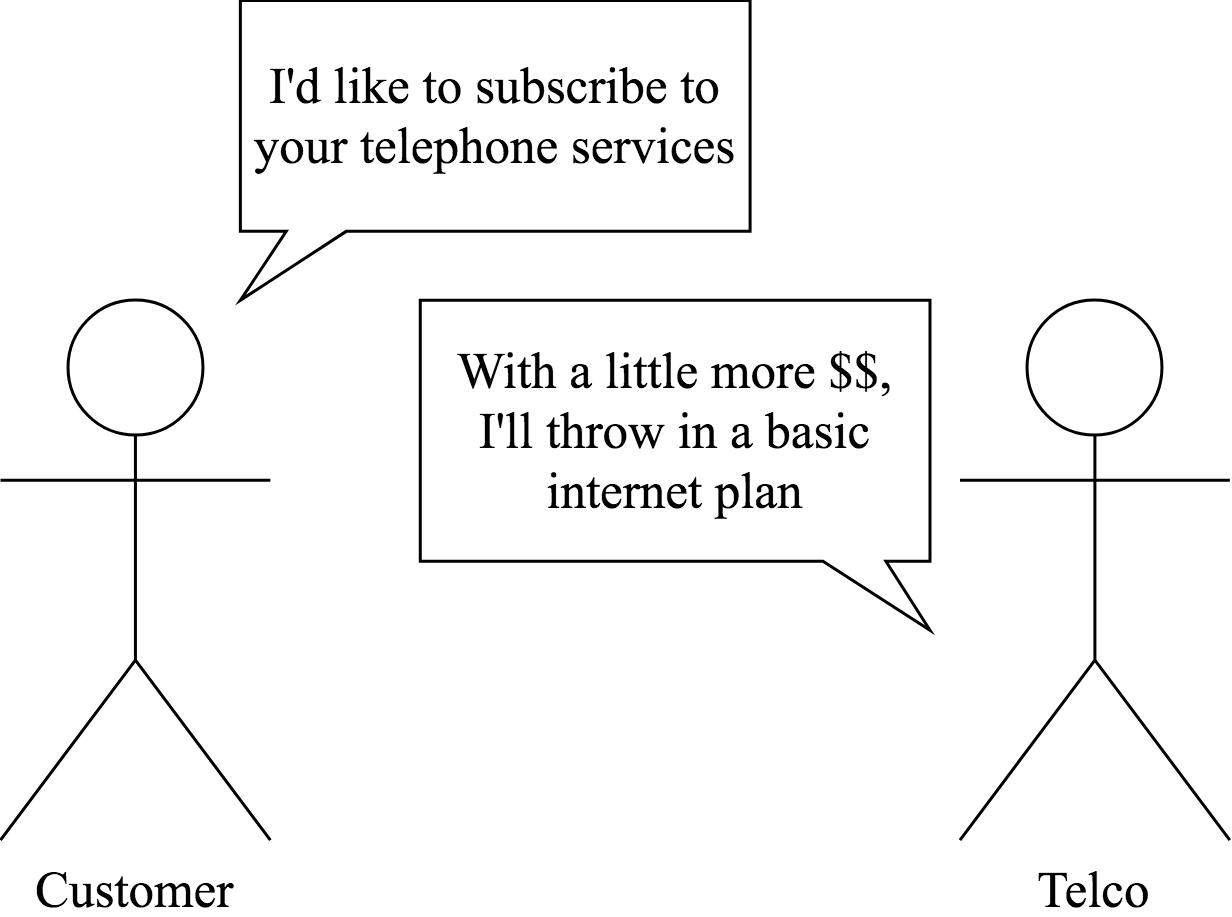

**FACT 2: Over 50% of our exclusive phone customers churned within 1 month of activation.**

Proposal*: Improve our phone service policy and cernter around the customer, not Telco. However, Since over half of our current exclusive phone active users have been with us for over 2 years, we have already been improving in that regard.

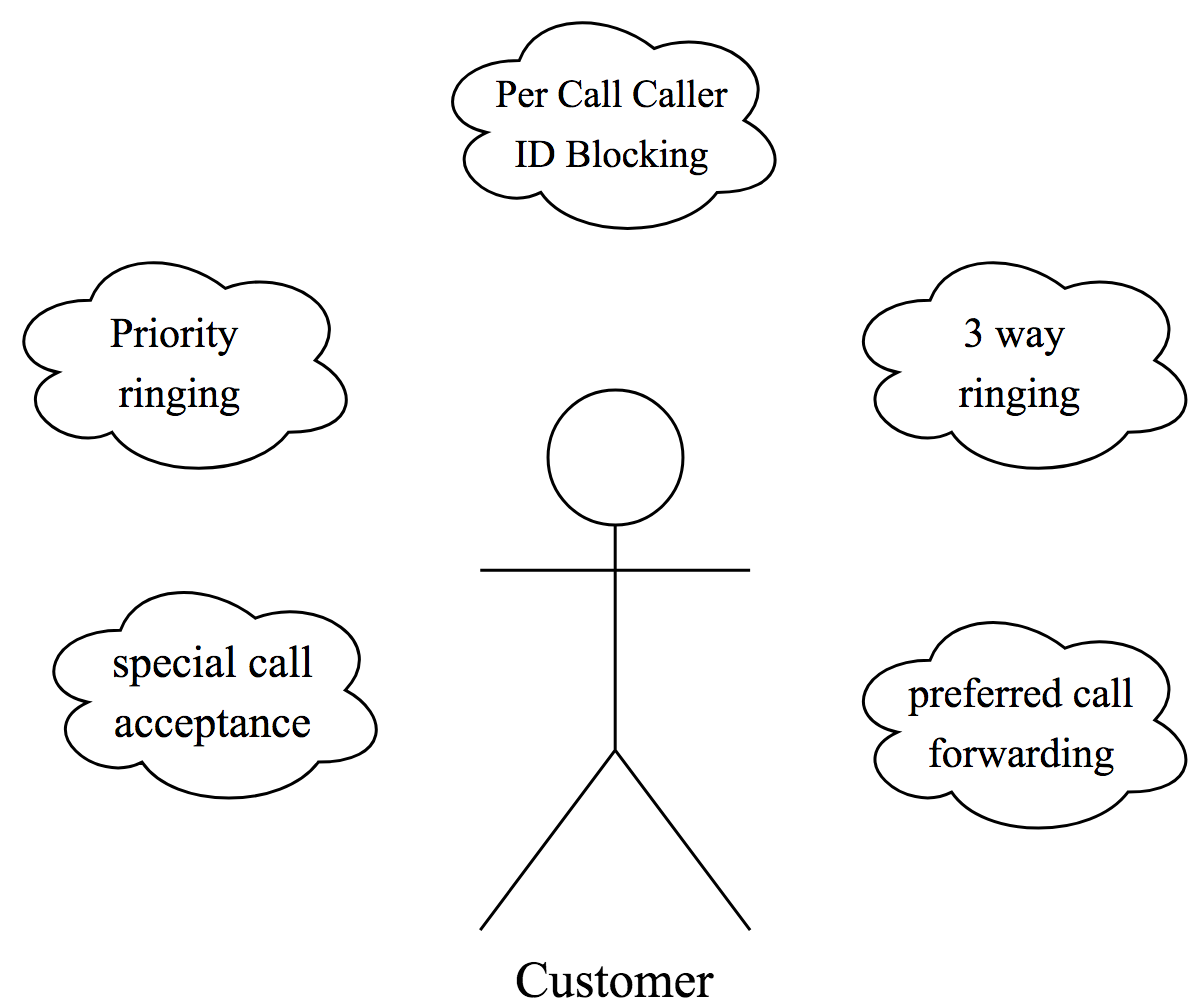

**FACT 3: Fiber Optic Internet users stay longer with us than DSL users**

Proposal: DSL and Fiber Optic internet Service have their advantages. Fiber Optic is Faster, while DSL is available in most areas and is more affordable. Customers need an internet service that suits their needs like location, bandwidth usage, price. We could offer FO internet packages with discounted prices for larger businesses (or larger bandwidth-consuming individuals).

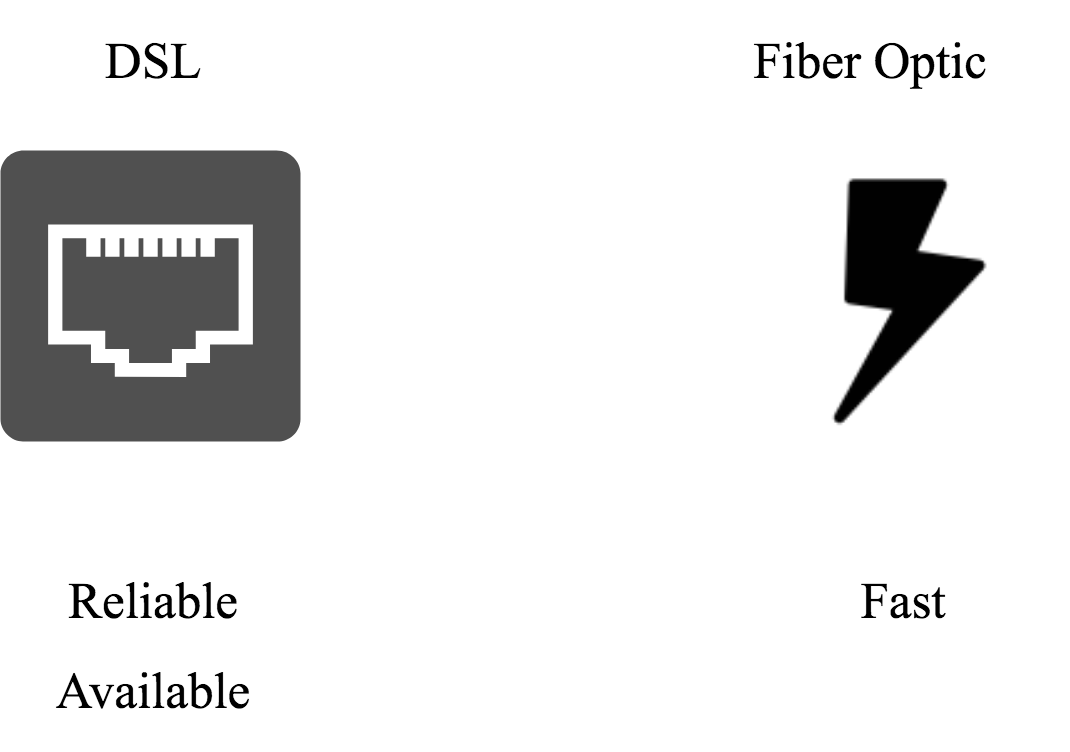

**FACT 4: Users with Technical Support stay with us much longer than users without.**

Proposal: Bundle Technical support with Internet Subscription (free at least for a limited time if expensive)

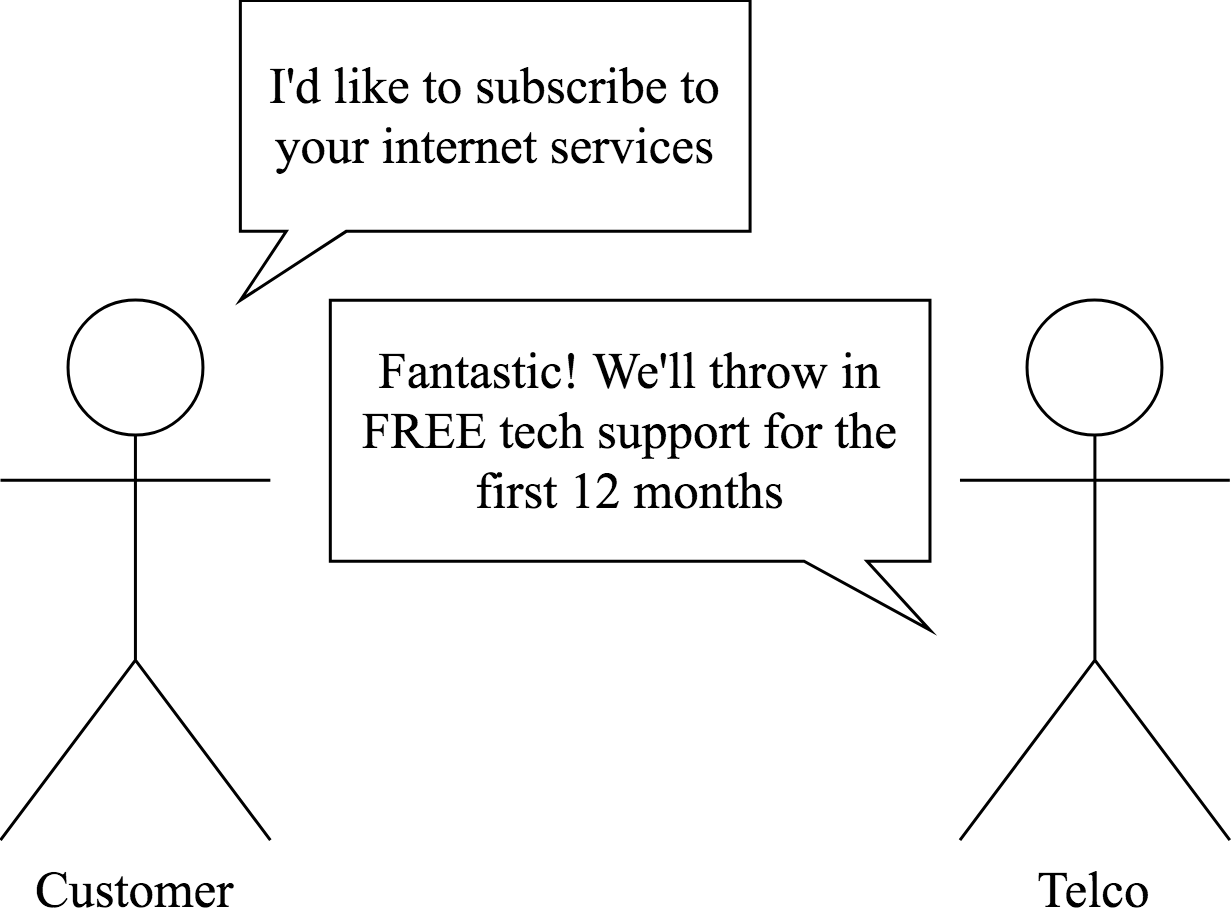

# 9 Machine Learning?

Before we think about machine learning, we need to ensure there is a problem to solve in the first place. Given transaction history by users with our competitors, We can predict when they are likely to churn. Either regressed in terms of "number of months till churn" or create a binary classifier which answers "Will churn in X months". I am not doing that in this notebook.

# 10 Appendix

## 10.1 Hypothesis Testing

For the comparison of 2 or more groups done throughout this notebook, we cannot say the tenure of one is greater/less than the others without conducting a test of significance. For 2 comparing 2 groups, I defined the stat_test function.

### 10.1.1 For 2 groups

I wanted to conduct the t-Test which assumes data is:

- Normally distributed: Tested using the Spairo Wilk test
- Homoscendastic: The 2 groups have equal variance is tested with the Levene Test

If the normality assumption is violated, I have 2 options:

- Convert the data into a normal distribution. How?
    - Try taking the log of data
    - Box Cox
    
- Perform the Mann Whiteney U-Test (which assumes data is i.i.d)

If neither method works to convert data into a normal distribution, then we simply perform the U-Test.

### 10.1.2 For more than 2 groups

I wanted to conduct ANOVA which assumes the normal distribution and equal variances. However, it is usually the case that the normality assumption is violated. We could use Kruskal's H-Test, but the null hypothesis is weak.

If $H_0$ is rejected, we have no idea which groups have different medians. Hence, I perform the pairwise Mann Whiteney U test in case the assumptions for ANOVA fail.